In [4]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
import ProgressMeter
using LinearAlgebra
using WAV

In [184]:
include("helpers/aida_segmentation.jl")
include("helpers/aida_snr.jl")
include("helpers/aida_ar.jl")
include("models_inferences.jl")

batch_coupled_learning (generic function with 1 method)

In [185]:
# load bar sound
br, fs = wavread("sound/environment/bar.wav");
# train sound
tr, fs = wavread("sound/environment/train.wav")

([0.003204443494979705; 3.051850947599719e-5; … ; -0.007019257179479354; 0.0022583697012237922], 8000.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x40, 0x1f, 0x00, 0x00, 0x80, 0x3e, 0x00, 0x00, 0x02, 0x00, 0x10, 0x00]), WAVChunk(:LIST, UInt8[0x49, 0x4e, 0x46, 0x4f, 0x49, 0x4e, 0x41, 0x4d, 0x08, 0x00  …  0x73, 0x70, 0x65, 0x63, 0x74, 0x6f, 0x72, 0x4a, 0x00, 0x00]), WAVChunk(Symbol("id3 "), UInt8[0x49, 0x44, 0x33, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x26  …  0x07, 0x00, 0x00, 0x00, 0x38, 0x2e, 0x38, 0x2e, 0x31, 0x37])])

In [186]:
br_seg = get_frames(br, fs)
tr_seg = get_frames(tr, fs)

352×80 Matrix{Float64}:
  0.00320444    3.05185e-5  -0.00689718  …  -0.0013123    -0.00341807
 -0.0234993    -0.0253914   -0.035371       -0.0144047    -0.0124516
  0.00573748   -0.00305185   0.00762963     -0.00976592   -0.00824
  0.00332652   -0.00738548  -0.00473037      0.0120548     0.0036317
 -0.00146489    0.00338755   0.00112918      0.016419      0.00628681
  0.00253304    0.00723289   0.00515763  …   0.022187      0.0114139
 -0.00338755   -0.00964385  -0.0119938       0.0158696     0.00735496
  0.00344859    0.00189215   0.0108341      -0.0477615    -0.0412305
  0.0707419     0.0713218    0.0561235       0.0297555     0.0493484
 -0.0222175    -0.00524918   0.0011597      -0.000640889   0.00384533
  0.0139164     0.0117191    0.0143132   …  -0.00744652   -0.000183111
 -0.00354015   -0.00341807   0.00845363      0.035493      0.0387585
 -0.0104373    -0.0148625    0.00830103      0.0458388     0.0269173
  ⋮                                      ⋱                
 -0.000885037   

In [200]:
vmp_iter = 50
totseg = 10
# totseg = size(br_seg, 1)
ar_order_1 = 2
ar_order_2 = 2

fe_br = zeros(totseg, vmp_iter)
fe_tr = zeros(totseg, vmp_iter)
fe_gaussian = zeros(totseg, vmp_iter);
priors_ar_1 = Dict(:mθ => zeros(ar_order_1), 
                   :vθ =>Matrix{Float64}(I, ar_order_1, ar_order_1)
                   :aγ => 1.0, :bγ => 1e-4)

priors_ar_1 = Dict(:mθ => ones(ar_order_1), 
                   :vθ =>1e2*Matrix{Float64}(I, ar_order_1, ar_order_1)
                   :aγ => 2.0, :bγ => 1e-4)

segments = tr_seg
ProgressMeter.@showprogress for segnum in 1:totseg
    γ, θ, xs, fe = lar_inference(segments[segnum, :], ar_order_1, vmp_iter, 1e-12, priors=priors_ar_1)
    mθ, vθ = mean(θ), cov(θ)
    mγ = mean(γ)
    fe_br[segnum, :] = fe
    
    γ, θ, xs, fe = lar_inference(segments[segnum, :], ar_order_2, vmp_iter, 1e-12, priors=priors_ar_2)
    mθ, vθ = mean(θ), cov(θ)
    mγ = mean(γ)
    fe_tr[segnum, :] = fe
    
    x, γ, fe = inference_gaussian(segments[segnum, :], vmp_iter)
    mx, vx = mean(x), cov(x)
    mγ = mean(γ)
    fe_gaussian[segnum, :] = fe
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


In [203]:
lowest_fe = [findmin([x[end], y[end], z[end]])[2] for (x, y, z) in zip(eachrow(fe_br), eachrow(fe_tr), eachrow(fe_gaussian))]
findall(isequal(1), lowest_fe)

3-element Vector{Int64}:
 3
 4
 6

In [149]:
function model_posteriors(m_lh, m_pr)
    model_evidence = mapreduce(x -> x[1]*x[2], +, zip(m_lh, m_pr))
    posteriors = map(x -> x[1]*x[2], zip(m_lh, m_pr)) ./ model_evidence
end

model_posteriors (generic function with 1 method)

### Markov model

In [139]:
using Random

function rand_vec(distribution::Categorical) 
    k = ncategories(distribution)
    s = zeros(k)
    s[ rand(distribution) ] = 1.0
    s
end

function generate_data(n_samples, Â, B̂; seed = 124)
    Random.seed!(seed)
    
    # Transition probabilities (some transitions are impossible)
    A = Â
    # Observation noise
    B = B̂
    # Initial state
    s_0 = zeros(size(A, 1)); s_0[1] = 1.0
    # Generate some data
    s = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
    x = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the observations
    
    s_prev = s_0
    
    for t = 1:n_samples
        a = A * s_prev
        s[t] = rand_vec(Categorical(a ./ sum(a)))
        b = B * s[t]
        x[t] = rand_vec(Categorical(b ./ sum(b)))
        s_prev = s[t]
    end
    
    return x, s
end

generate_data (generic function with 2 methods)

In [125]:
function create_B(dims)
    base = ones(dims); base[1] = 1e2
    B = hcat(base)'
    for i in 1:dims-1
        base = circshift(base, 1)
        B = vcat(B, hcat(base)')
    end
    B
end

create_B (generic function with 1 method)

In [133]:
@model [ default_factorisation = MeanField() ] function hmm(n, order)
    
    A ~ MatrixDirichlet(ones(order, order)) 
    B ~ MatrixDirichlet(create_B(order))
    
    s_0 ~ Categorical(fill(1.0 / order, order))
    
    s = randomvar(n)
    x = datavar(Vector{Float64}, n)
    
    s_prev = s_0
    
    for t in 1:n
        s[t] ~ Transition(s_prev, A) where { q = q(out, in)q(a) }
        x[t] ~ Transition(s[t], B)
        s_prev = s[t]
    end
    
    return s, x, A, B
end

hmm (generic function with 2 methods)

In [134]:
function inference_hmm(data, vmp_iter, order)
    n = length(data)
    
    model, (s, x, A, B) = hmm(n, order, options = (limit_stack_depth = 500, ))
    
    sbuffer = keep(Vector{Marginal})
    Abuffer = keep(Marginal)
    Bbuffer = keep(Marginal)
    fe      = ScoreActor(Float64)
    
    ssub  = subscribe!(getmarginals(s), sbuffer)
    Asub  = subscribe!(getmarginal(A), Abuffer)
    Bsub  = subscribe!(getmarginal(B), Bbuffer)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)
    
    setmarginal!(A, vague(MatrixDirichlet, order, order))
    setmarginal!(B, MatrixDirichlet(create_B(order)))
    
    foreach(s) do svar
        setmarginal!(svar, vague(Categorical, 3))
    end
    
    ProgressMeter.@showprogress for i in 1:vmp_iter
        update!(x, data)
    end
    
    return map(getvalues, (sbuffer, Abuffer, Bbuffer, fe))
end

inference_hmm (generic function with 2 methods)

In [140]:
A = [0.7 0.3; 0.1 0.9] 
B = [0.9 0.1; 0.1 0.9] 
x_data, s_data = generate_data(100, A, B);

In [141]:
s, A, B, fe = inference_hmm(x_data, 100, 2);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [142]:
mean(A[end])

2×2 Matrix{Float64}:
 0.821648  0.387479
 0.178352  0.612521

In [143]:
mean(B[end])

2×2 Matrix{Float64}:
 0.990903    0.00879125
 0.00909659  0.991209

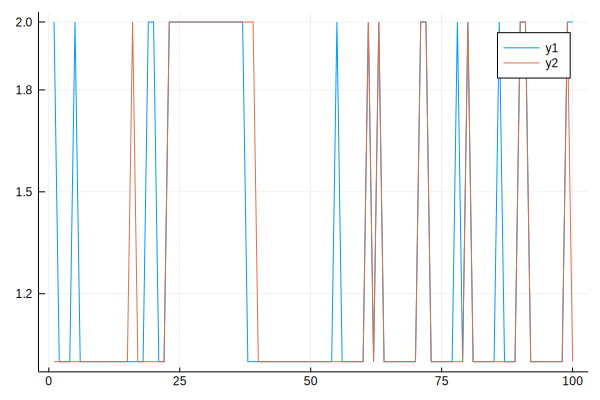

In [144]:
plot(round.(mean.(s[end])))
plot!(argmax.(s_data))